In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, AveragePooling2D, MaxPooling2D

# Download data

In [2]:
import zipfile
from urllib.request import urlretrieve

def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("")
    os.remove(zip_path)    
    
url = "https://storage.googleapis.com/kaggle-data-sets/3258/5337/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586457678&Signature=Fpk8Z%2BNCFNBkVKBztZZR5QHgmGBdfjXb6g3f8SWjGz8bXPgdh3jqslYfZ3EorgG6SvMcZ17OlGQ8zkrzWbGkN0Va5cHRVq5LYfDrJBw2rIbmaw3S4TUFR6XZTgwjmfIrD69G6w7Q1US4SydNmKb42Duf7pbP51VrK3RTPBHqowBvvM5wzQpkmDd6UMkIxKVltsZRtV%2F8SLuQKz%2BtUXP5dc88vXUU1M3REQ2NuFjrOakd3%2BINEzPnIDbIbpdedD4hFe95zBjNiMURqW4a8u4FplVVw9xI4ugdqOukzKC6pXnBetlgy5R0eyUJP2Udf63tp0s6NN%2FjOp8Clf5P9yOe%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dsign-language-mnist.zip"
download_file(url, "sign-mnist")

HTTPError: HTTP Error 400: Bad Request

# Read data

In [10]:
def unzip(data):
    first = [p[0] for p in data]
    second = [p[1] for p in data]
    return np.array(first), np.array(second)

def read_images_and_labels(filename):
    images = []
    with open(filename) as f:
        f.readline()
        for line in f:
            label, *values = line.strip().split(',')
            image = np.array([float(v) for v in values]) / 255
            image.resize((28, 28, 1))
            images.append((int(label), image))
            
    return images

test_images = read_images_and_labels("sign_mnist_test.csv")
train_images = read_images_and_labels("sign_mnist_train.csv")

train_len = len(train_images)
val_len = int(train_len * 0.1)
val_images = train_images[:val_len]
train_images = train_images[val_len:]

val_labels, val_images = unzip(val_images)
train_labels, train_images = unzip(train_images)
test_labels, test_images = unzip(test_images)

classes = sorted(list(set(list(train_labels) + list(val_labels) + list(test_labels))))
num_classes = max(classes) + 1

## Plot data

Train len: 24710
Val len: 2745
Test len: 7172


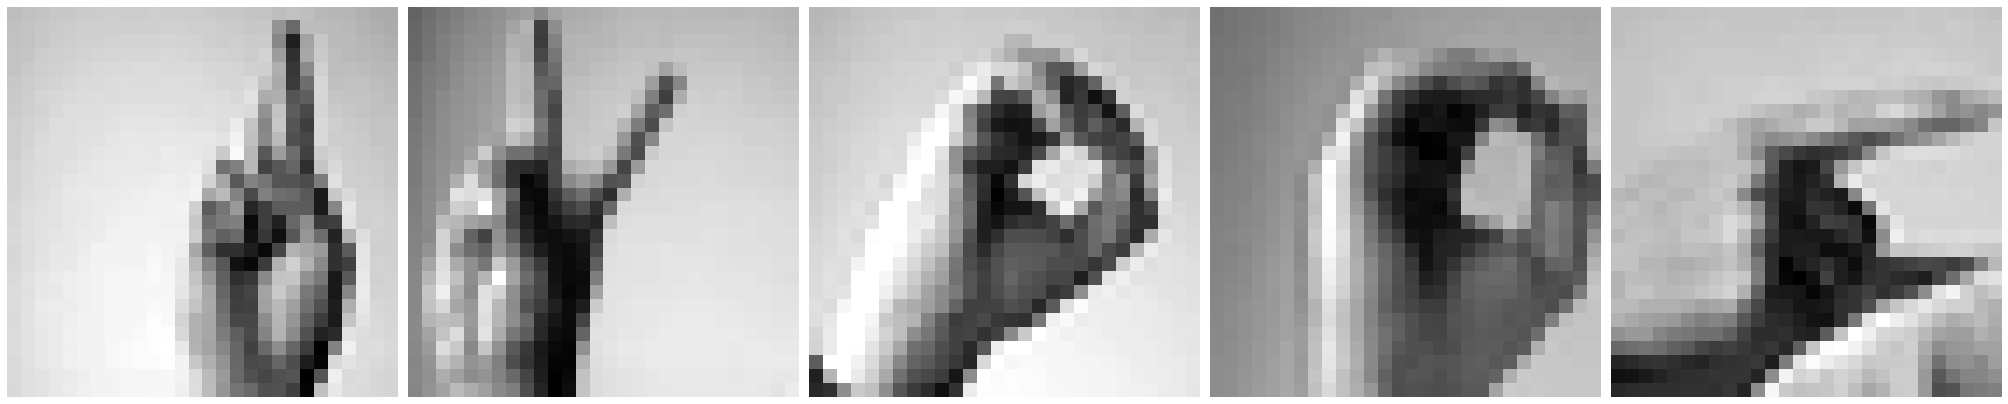

In [11]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(28,28))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        img = np.array(img)
        img.resize((28, 28))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Train len: %d" % len(train_images))
print("Val len: %d" % len(val_images))
print("Test len: %d" % len(test_images))

plot_images([random.choice(train_images) for i in range(5)])

# Simple model

In [22]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28, 28, 1), padding="same"),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    Conv2D(64, kernel_size=(2, 2), strides=(1, 1), activation='tanh', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    Flatten(),
    Dense(120, activation="relu"),
    Dropout(0.1),
    Dense(120, activation="relu"),
    Dropout(0.1),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
average_pooling2d_6 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)         

In [13]:
history = model.fit(
    train_images, train_labels, 
    epochs=5, 
    validation_data=(val_images, val_labels), 
    batch_size=32)

Train on 24710 samples, validate on 2745 samples
Epoch 1/5
24710/24710 [==============================] - 15s 611us/sample - loss: 1.0827 - accuracy: 0.6545 - val_loss: 0.1696 - val_accuracy: 0.9428
Epoch 2/5
24710/24710 [==============================] - 14s 565us/sample - loss: 0.1101 - accuracy: 0.9659 - val_loss: 0.0184 - val_accuracy: 0.9967
Epoch 3/5
24710/24710 [==============================] - 17s 690us/sample - loss: 0.0395 - accuracy: 0.9885 - val_loss: 0.0039 - val_accuracy: 0.9996
Epoch 4/5
24710/24710 [==============================] - 16s 654us/sample - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.0266 - val_accuracy: 0.9902
Epoch 5/5
24710/24710 [==============================] - 15s 596us/sample - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.0016 - val_accuracy: 1.0000


7172/7172 [==============================] - 1s 117us/sample - loss: 1.8453 - accuracy: 0.4032


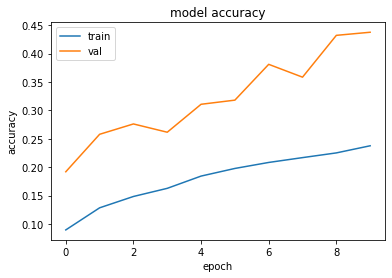

In [20]:
model.evaluate(test_images, test_labels)

def plot_history(history):
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history)

# Augmented images

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_aug_gen_train = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

image_aug_gen_val = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

image_aug_gen_val = ImageDataGenerator()

train_aug_data_gen = image_aug_gen_train.flow(
    train_images, train_labels, 
    batch_size=64, shuffle=True)

val_aug_data_gen = image_aug_gen_val.flow(
    val_images, val_labels, 
    batch_size=64, shuffle=True)

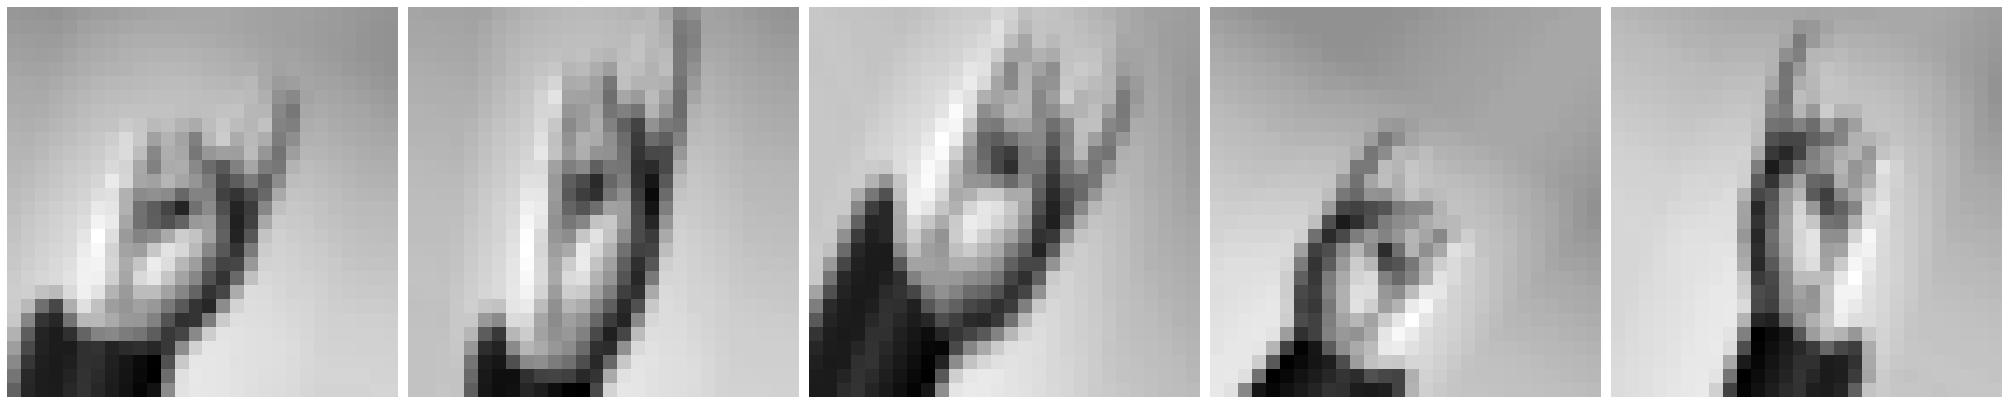

In [16]:
augmented_images = [train_aug_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [30]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28, 28, 1), padding="same"),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    Conv2D(64, kernel_size=(2, 2), strides=(1, 1), activation='tanh', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    Flatten(),
    Dense(120, activation="relu"),
    Dropout(0.1),
    Dense(120, activation="relu"),
    Dropout(0.1),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)         

In [31]:
history = model.fit_generator(train_aug_data_gen, epochs=60, validation_data=val_aug_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 387 steps, validate for 43 steps
Epoch 1/60
387/387 [==============================] - 28s 71ms/step - loss: 2.9652 - accuracy: 0.1060 - val_loss: 2.2963 - val_accuracy: 0.2860
Epoch 2/60
387/387 [==============================] - 28s 73ms/step - loss: 2.5482 - accuracy: 0.2149 - val_loss: 1.8060 - val_accuracy: 0.4448
Epoch 3/60
387/387 [==============================] - 28s 71ms/step - loss: 2.3160 - accuracy: 0.2785 - val_loss: 1.5295 - val_accuracy: 0.5260
Epoch 4/60
387/387 [==============================] - 18s 48ms/step - loss: 2.1392 - accuracy: 0.3260 - val_loss: 1.2817 - val_accuracy: 0.6011
Epoch 5/60
387/387 [==============================] - 18s 46ms/step - loss: 2.0036 - accuracy: 0.3596 - val_loss: 1.1688 - val_accuracy: 0.6350
Epoch 6/60
387/387 [==============================] - 17s 44ms/step - loss: 1.8848 - accuracy: 0.3956 - val_loss: 1.0407 - val_accuracy: 0.6809
Epoch 7/60
387/387 [=======================

387/387 [==============================] - 28s 71ms/step - loss: 0.8130 - accuracy: 0.7323 - val_loss: 0.1692 - val_accuracy: 0.9545
Epoch 57/60
387/387 [==============================] - 29s 76ms/step - loss: 0.7991 - accuracy: 0.7299 - val_loss: 0.1769 - val_accuracy: 0.9464
Epoch 58/60
387/387 [==============================] - 29s 74ms/step - loss: 0.7937 - accuracy: 0.7351 - val_loss: 0.1776 - val_accuracy: 0.9556
Epoch 59/60
387/387 [==============================] - 28s 74ms/step - loss: 0.7909 - accuracy: 0.7342 - val_loss: 0.1614 - val_accuracy: 0.9537
Epoch 60/60
387/387 [==============================] - 29s 74ms/step - loss: 0.7778 - accuracy: 0.7374 - val_loss: 0.1469 - val_accuracy: 0.9614


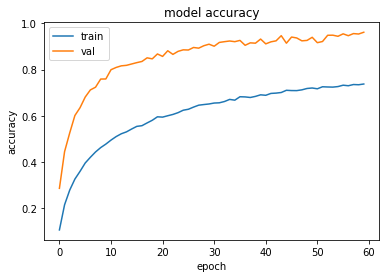

7172/7172 [==============================] - 3s 366us/sample - loss: 0.1898 - accuracy: 0.9513


[0.1898027925320464, 0.9513385]

In [32]:
plot_history(history)
model.evaluate(test_images, test_labels)

# VGG19 network

In [33]:
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg_base.layers[:5]:
    layer.trainable = False
    
x = vgg_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(25, activation="softmax")(x)

vgg_model = Model(vgg_base.input, predictions)

vgg_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

80142336/80134624 [==============================] - 14s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____________________________________________________________

## Resize data to fit VGG19

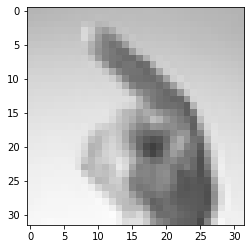

In [34]:
def gray_to_rgb(img):
    img = np.repeat(img, 3, 2)
    return img

train_images_3p = np.array([gray_to_rgb(img) for img in tf.image.resize(train_images, (32, 32))])
val_images_3p = np.array([gray_to_rgb(img) for img in tf.image.resize(val_images, (32, 32))])
test_images_3p = np.array([gray_to_rgb(img) for img in tf.image.resize(test_images, (32, 32))])

plt.imshow(train_images_3p[1])

In [35]:
vgg_model.fit(
    train_images_3p, train_labels, 
    epochs=2,
    validation_data=(val_images_3p, val_labels), 
    validation_steps=10,
    verbose=1)

Train on 24710 samples, validate on 2745 samples
Epoch 1/2
24710/24710 [==============================] - 859s 35ms/sample - loss: 0.7808 - accuracy: 0.7499 - val_loss: 0.0015 - val_accuracy: 0.9969
Epoch 2/2
24710/24710 [==============================] - 1025s 41ms/sample - loss: 0.0665 - accuracy: 0.9841 - val_loss: 1.2854e-05 - val_accuracy: 1.0000


In [36]:
vgg_model.evaluate(test_images_3p, test_labels)

7172/7172 [==============================] - 33s 5ms/sample - loss: 0.0080 - accuracy: 0.9980


[0.008041589267465897, 0.99804795]